### Import self-written layers from *nunes*

In [1]:
import matplotlib.pyplot as plt
import tqdm

import nunes
import nunes.nn as nn
import nunes.optimizers as nuotps

In [2]:
class ConvReLU(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, padding: int = 0):
        super().__init__()
        self.conv = nn.Conv2D(in_channels, out_channels, kernel_size=(3, 3), stride=stride, padding=padding)
        self.relu = nn.LeakyReLU(slope=1e-2)

    def forward(self, x: nunes.Tensor) -> nunes.Tensor:
        x = self.conv(x)
        x = self.relu(x)

        return x


class ClassifierCnn(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.block1 = ConvReLU(1, 8, stride=2, padding=1)
        self.block2 = ConvReLU(8, 16, stride=2)
        self.block3 = ConvReLU(16, 32, stride=2)
        self.pool = nn.MaxPool2D(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(32, num_classes)

    def forward(self, x: nunes.Tensor) -> nunes.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x

In [3]:
model = ClassifierCnn(num_classes=10).train()
model(nunes.randn(1, 1, 28, 28)).shape

(1, 10)

In [4]:
model

ClassifierCnn(
	(block1): ConvReLU(
		(conv): Conv2D(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=True)
		(relu): LeakyReLU(slope=0.01)
	)
	(block2): ConvReLU(
		(conv): Conv2D(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), bias=True)
		(relu): LeakyReLU(slope=0.01)
	)
	(block3): ConvReLU(
		(conv): Conv2D(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), bias=True)
		(relu): LeakyReLU(slope=0.01)
	)
	(pool): MaxPool2D(kernel_size=(2, 2), stride=(2, 2))
	(flatten): Flatten()
	(classifier): Linear(in_features=32, out_features=10, bias=True)
)

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as td

train = MNIST(root="data/mnist", train=True, transform=transforms.ToTensor())
test = MNIST(root="data/mnist", train=False, transform=transforms.ToTensor())

In [6]:
model = ClassifierCnn(num_classes=10)
optimizer = nuotps.Adam(model.parameters(), lr=2e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [7]:
batch_size = 128
epochs = 3
losses = []

for e in range(epochs):
    progress = tqdm.tqdm(
        td.DataLoader(train, batch_size=batch_size, shuffle=True)
    )
    for x, y in progress:
        x = nunes.from_torch(x)
        y = nunes.from_torch(y)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.set_postfix_str(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

model.save("pretrained/cnn.npy")

100%|██████████| 469/469 [32:41<00:00,  4.18s/it, loss: 0.2553]


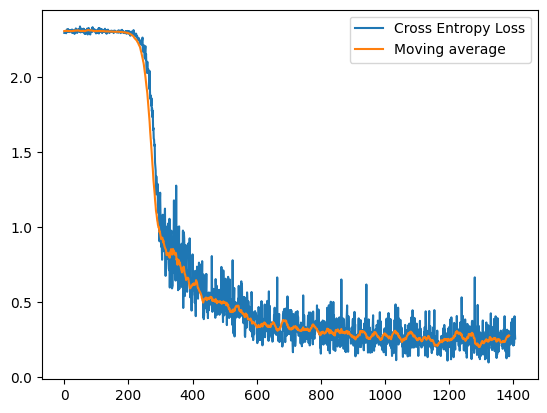

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


plt.plot(losses, label="Cross Entropy Loss")
plt.plot(moving_average(losses, 20), label="Moving average")
plt.legend()

In [9]:
model = ClassifierCnn.load("pretrained/cnn.npy")

preds = []
truth = []

for x, y in tqdm.tqdm(td.DataLoader(test, batch_size=batch_size)):
    x = nunes.from_torch(x)
    y = nunes.from_torch(y)

    pred = model(x).numpy()

    preds.append(pred)
    truth.append(y.numpy())

100%|██████████| 79/79 [00:39<00:00,  1.99it/s]


In [10]:
import numpy as np

preds = np.vstack(preds).argmax(axis=1)
truth = np.concatenate(truth)

In [11]:
mask = preds == truth
print(f"Accuracy: {mask.mean():.4f}")

Accuracy: 0.9346


In [12]:
from sklearn.metrics import f1_score, recall_score, precision_score

In [13]:
recall = recall_score(truth, preds, average="macro")
precision = precision_score(truth, preds, average="macro")
f1 = f1_score(truth, preds, average="macro")

print(f"{recall=:.4f}, {precision=:.4f}, {f1=:.4f}")

recall=0.9336, precision=0.9342, f1=0.9336


### Checkout some examples

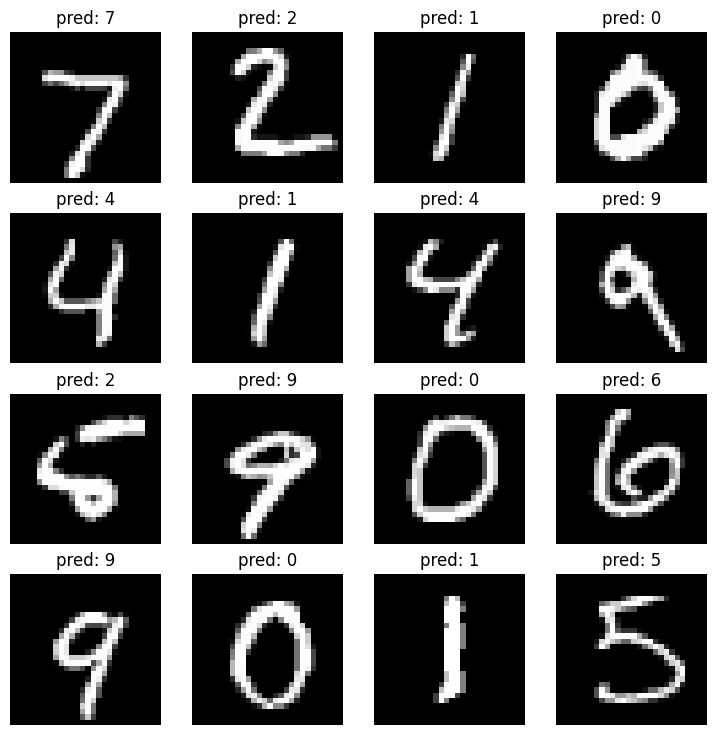

In [14]:
images = []

for x, y in td.DataLoader(test, batch_size=16):
    images = x.numpy()
    logits = model(nunes.tensor(images))
    classes = logits.numpy().argmax(axis=1)
    break

_, axes = plt.subplots(4, 4, figsize=(9, 9))

for idx in range(16):
    i, j = idx // 4, idx % 4
    axes[i, j].axis("off")
    axes[i, j].set_title(f"pred: {preds[idx]}")
    axes[i, j].imshow(images[idx][0], cmap="gray")